In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import glob,os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import seaborn as sns
# sns.set_style("darkgrid",{"font.sans-serif":['KaiTi', 'Arial']})
# plt.style.use('ggplot')
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置
# plt.style.use('ggplot')
%matplotlib inline

In [ ]:
dfs=[]
for infile in glob.glob('./StocksOPT/data/temp/forStocks/values/*.csv'):
    df = pd.read_csv(infile, index_col='date',parse_dates=True)
#     print(infile[-13:-4])
#     close = infile[-13:-4]
#     df.rename(columns={'日期':'date','收盘价(元)':close},inplace=True)
#     df.index=pd.to_datetime(df.date)
#     df = df[[close]]
    
    # name cols
    name = os.path.splitext(os.path.basename(infile))[0]
    df.name=name
    
    dfs.append(df)

In [3]:
dfs.sort(key=lambda x:x.name, reverse=False)
[(df.name,df.index[0]) for df in dfs]

[('Values_CVaR_MinRisk', Timestamp('2023-07-31 00:00:00')),
 ('Values_CVaR_Sharpe', Timestamp('2023-07-31 00:00:00')),
 ('Values_EVaR_MinRisk', Timestamp('2023-07-31 00:00:00')),
 ('Values_EVaR_Sharpe', Timestamp('2023-07-31 00:00:00')),
 ('Values_HERC', Timestamp('2023-07-31 00:00:00')),
 ('Values_HRP', Timestamp('2023-07-31 00:00:00')),
 ('Values_MV_MinRisk', Timestamp('2023-07-31 00:00:00')),
 ('Values_MV_Sharpe', Timestamp('2023-07-31 00:00:00')),
 ('Values_NCO_MinRisk', Timestamp('2023-07-31 00:00:00')),
 ('Values_NCO_Sharpe', Timestamp('2023-07-31 00:00:00')),
 ('Values_RP_MinRisk', Timestamp('2023-07-31 00:00:00')),
 ('Values_RP_Sharpe', Timestamp('2023-07-31 00:00:00'))]

In [4]:
# concat
df = pd.concat(dfs, axis=1, keys=[df.name for df in dfs], names=['Pair','Price'])
df.head(3)

Pair       Values_CVaR_MinRisk Values_CVaR_Sharpe Values_EVaR_MinRisk  \
Price             CVaR_MinRisk        CVaR_Sharpe        EVaR_MinRisk   
date                                                                    
2023-07-31            0.998500           0.998500            0.998500   
2023-08-01            0.995035           1.009967            0.997104   
2023-08-02            0.988222           1.006222            0.990396   

Pair       Values_EVaR_Sharpe Values_HERC Values_HRP Values_MV_MinRisk  \
Price             EVaR_Sharpe        HERC        HRP        MV_MinRisk   
date                                                                     
2023-07-31           0.998500    0.998500   0.998500          0.998500   
2023-08-01           1.013527    0.998940   0.996431          0.995828   
2023-08-02           1.009382    0.990601   0.988507          0.988862   

Pair       Values_MV_Sharpe Values_NCO_MinRisk Values_NCO_Sharpe  \
Price             MV_Sharpe        NCO_MinRisk        NCO_Sharpe   
date                                                               
2023-07-31         0.998500           0.998500          0.998500   
2023-08-01         1.015328           0.995714          1.009967   
2023-08-02         1.013249           0.988507          1.006222   

Pair       Values_RP_MinRisk Values_RP_Sharpe  
Price             RP_MinRisk        RP_Sharpe  
date                                           
2023-07-31          0.998500         0.998500  
2023-08-01          0.999610         0.999610  
2023-08-02          0.992145         0.992145

In [5]:
df = df.droplevel('Pair', axis=1)   # 或者 df = df.droplevel(level=0, axis=1)
df.dropna(inplace=True)

In [6]:
df.head(3)

Price       CVaR_MinRisk  CVaR_Sharpe  EVaR_MinRisk  EVaR_Sharpe      HERC  \
date                                                                         
2023-07-31      0.998500     0.998500      0.998500     0.998500  0.998500   
2023-08-01      0.995035     1.009967      0.997104     1.013527  0.998940   
2023-08-02      0.988222     1.006222      0.990396     1.009382  0.990601   

Price            HRP  MV_MinRisk  MV_Sharpe  NCO_MinRisk  NCO_Sharpe  \
date                                                                   
2023-07-31  0.998500    0.998500   0.998500     0.998500    0.998500   
2023-08-01  0.996431    0.995828   1.015328     0.995714    1.009967   
2023-08-02  0.988507    0.988862   1.013249     0.988507    1.006222   

Price       RP_MinRisk  RP_Sharpe  
date                               
2023-07-31    0.998500   0.998500  
2023-08-01    0.999610   0.999610  
2023-08-02    0.992145   0.992145

## 取夏普比率最高的前12个优化模型，然后画图：

先求收益率矩阵

In [7]:
R = np.log(df / df.shift())
R = pd.DataFrame(R)

In [8]:
R.dropna(inplace=True) # 转换为DataFrame格式，要不用不了apply

In [9]:
# 把计算出来的年化share比率值放到df最后一行
df.loc['Sharpe'] = R.apply(lambda x: (np.sqrt(252) * np.mean(x)) / (np.std(x)))

In [10]:
df_sorted = df.sort_values(by='Sharpe',axis=1,ascending=False)  # 按照sharpe比率大小排序
df_sorted = df_sorted.iloc[:-1,:]  #去掉sharpe那行

In [ ]:
dfl = pd.read_csv('./StocksOPT/data/DRL_trained_results/df_PPO_vgg1_Tanh_maxSharpe_arbitrage.csv',index_col='date',
                  usecols=["date","portfolio_value"],
                 parse_dates=True # 要解析下date，否则用concat时会出现NAN值
                 )

dfl.rename(columns={'portfolio_value': 'DRL'}, inplace=True)  # 重命名

In [12]:
df_plt=pd.concat([dfl.iloc[1:,:],df_sorted.iloc[:,:12]],axis=1)  # 合并drl和df_sorted

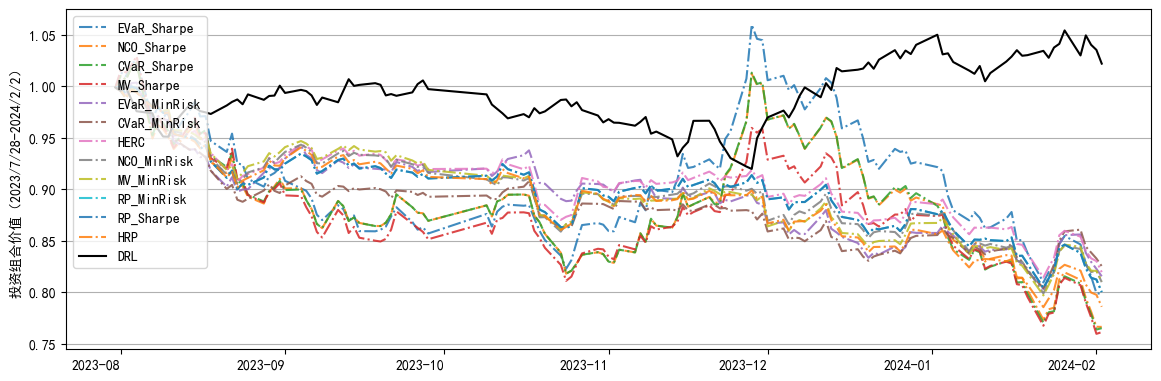

In [13]:
fig_stocks_values = plt.figure(figsize=(14,5))
# plt.suptitle('pass', fontsize=16,x=0.51,y=0.95)
ax_values = fig_stocks_values.add_subplot(1, 1, 1)

# 第一次绘图
df_plt.iloc[:,1:].plot(ax=ax_values,
                      alpha=0.85,
                      xlabel='',
                      linestyle='-.',
                      ylabel='投资组合价值（2023/7/28-2024/2/2）',
                      use_index=True)

# 第二次绘图
df_plt.iloc[:,0].plot(ax=ax_values, 
                     color="black",
                     xlabel='',
                     legend=True,
                     rot=0)

# 调整图例位置到左上角
ax_values.legend(loc='upper left')

# 添加网格
ax_values.grid(axis='y')

# ax_values.legend(bbox_to_anchor=(0.02, 0.98))  # 更精确地控制位置


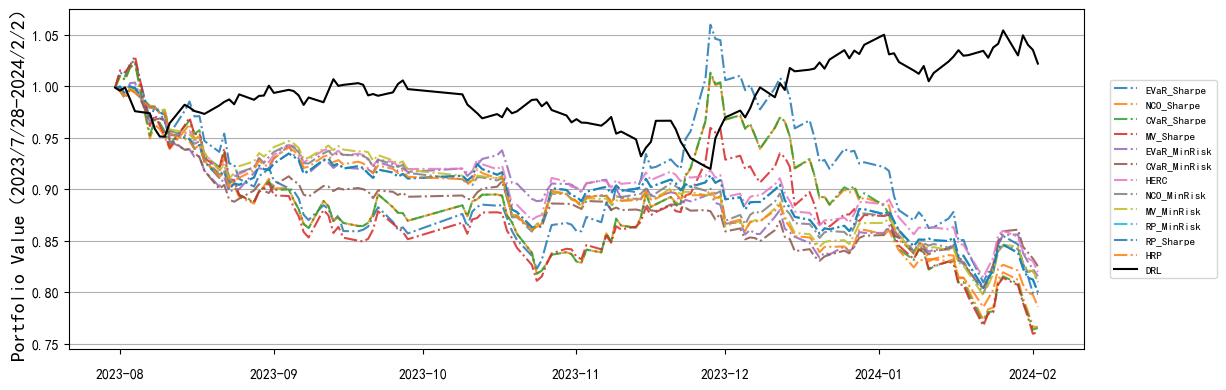

In [14]:
fig_stocks_values = plt.figure(figsize=(14,5))
ax_values = fig_stocks_values.add_subplot(1, 1, 1)

# 绘制主要数据
df_plt.iloc[:,1:].plot(ax=ax_values,
                      alpha=0.85,
                      xlabel='',
                      linestyle='-.',
                      # ylabel='投资组合价值（2023/7/28-2024/2/2）',
                      # ylabel='Portfolio Value',  
                      use_index=True)

# 绘制DRL黑色线条
df_plt.iloc[:,0].plot(ax=ax_values, 
                     color="black",
                     xlabel='',
                     legend=True,
                     rot=0)

# 设置 y 轴标签字体大小
ax_values.set_ylabel('Portfolio Value（2023/7/28-2024/2/2）', fontsize=14)
# ax_values.set_xlabel('Date', fontsize=16)

# 设置图例放在图形外面右侧
ax_values.legend(loc='center left', 
                bbox_to_anchor=(1.02, 0.5),  # 这会把图例放在图形右侧
                fontsize=8)

ax_values.grid(axis='y') 

# 设置 x 轴标签居中显示
ax_values.tick_params(axis='x', which='major', pad=10)
plt.xticks(ha='center')

# 调整布局，为右侧图例留出空间
plt.subplots_adjust(right=0.85)  # 这个数值可以调整，控制图例的位置


In [15]:
# 保存矢量图
fig_stocks_values.savefig('./img/plot_OPT_comparison_Stocks/OPT_comparison.svg', 
                        bbox_inches='tight',
                        dpi=300,
                        format='svg')

# 保存为PDF格式
fig_stocks_values.savefig('./img/plot_OPT_comparison_Stocks/OPT_comparison.pdf', 
            bbox_inches='tight', 
            dpi=300,
            format='pdf')